# Importing libraries

In [2041]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz

# Creating ticker symbol and setting it equal to stock of choice

In [2043]:
ticker_symbol = 'KO'
ko = yf.Ticker(ticker_symbol)

# Creating empty list to append values

In [2045]:
all_options_list = []

In [2046]:
for exp_date in ko.options:
    try:
        options_chain = ko.option_chain(exp_date)
        calls = options_chain.calls 
        puts = options_chain.puts
        calls['expirationDate'] = exp_date
        puts['expirationDate'] = exp_date
        all_options_data = all_options_list.append(calls)
        all_options_data = all_options_list.append(puts)
    except Exception as e:
        print(f'Error retrieving options for {exp_date}: {e}')

all_options_data = pd.concat(all_options_list, ignore_index=True)

## Turning list into a data frame

In [2048]:
all_options_data = pd.DataFrame(all_options_data)

# Creating new data frame with specific columns from original data frame

In [2050]:
new_df = all_options_data[['contractSymbol','strike','expirationDate', 'openInterest', 'volume', 'lastTradeDate']].copy()

# Extracting only the 'P' or 'C' from contract symbol

In [2052]:
new_df['optionType'] = new_df['contractSymbol'].str.extract(r'^\w{8}([CP])', expand=False)

# Changing time from column 'lastTradeDate' into pacific time

In [2054]:
new_df['lastTradeDate'] = pd.to_datetime(new_df['lastTradeDate'], utc=True)

pacific_tz = pytz.timezone("US/Pacific")
new_df['lastTradeDate'] = new_df['lastTradeDate'].dt.tz_convert(pacific_tz)

new_df['lastTradeDate_12hr'] = new_df['lastTradeDate'].dt.strftime("%Y-%m-%d %I:%M %p")

In [2055]:
new_df['lastTradeDate'] = pd.to_datetime(new_df['lastTradeDate'])
new_df['date_traded'] = new_df['lastTradeDate'].dt.date
new_df['time_traded'] = new_df['lastTradeDate'].dt.time

# Grouping all columns in data frame by the volume column

In [2057]:
grouped = new_df.groupby(['strike', 'optionType', 'expirationDate', 'volume', 'openInterest', 'date_traded', 'time_traded', 'lastTradeDate'])['volume'].sum()

# Sorting all rows in descending order to print rows with the most volume first

In [2059]:
grouped_sorted = grouped.sort_values(ascending=False)

# Setting option to display all rows in data frame

In [2061]:
pd.set_option('display.max_rows', None)

In [2062]:
grouped_sorted.head(10)

strike  optionType  expirationDate  volume  openInterest  date_traded  time_traded  lastTradeDate            
67.5    C           2025-09-19      2547.0  3024          2025-08-13   11:34:09     2025-08-13 11:34:09-07:00    2547.0
                    2025-08-15      2361.0  6824          2025-08-13   11:34:09     2025-08-13 11:34:09-07:00    2361.0
64.0    P           2025-08-15      2010.0  4342          2025-08-11   06:36:51     2025-08-11 06:36:51-07:00    2010.0
71.0    C           2025-08-15      1793.0  3480          2025-08-13   12:59:12     2025-08-13 12:59:12-07:00    1793.0
                    2025-08-22      1336.0  1322          2025-08-13   12:59:37     2025-08-13 12:59:37-07:00    1336.0
70.0    C           2025-08-15      1163.0  12512         2025-08-13   12:57:43     2025-08-13 12:57:43-07:00    1163.0
75.0    C           2025-09-05      1159.0  1524          2025-08-13   08:12:25     2025-08-13 08:12:25-07:00    1159.0
70.0    P           2025-08-15      880.0   8519  

# Filtering and creating new data frame to only print values where the strike is inbetween 60 and 80

In [2064]:
df_filtered = new_df[(new_df['strike'] >= 60) & (new_df['strike'] <= 80)]

# Grouping all columns in data frame by the volume column and sorting by descending order

In [2066]:
grouped_filtered = df_filtered.groupby(['strike', 'optionType', 'expirationDate', 'volume', 'openInterest', 'date_traded', 'time_traded'])['volume'].sum()
grouped_filtered_sorted = grouped_filtered.sort_values(ascending=False)

In [2067]:
print(grouped_filtered_sorted.head(10))

strike  optionType  expirationDate  volume  openInterest  date_traded  time_traded
67.5    C           2025-09-19      2547.0  3024          2025-08-13   11:34:09       2547.0
                    2025-08-15      2361.0  6824          2025-08-13   11:34:09       2361.0
64.0    P           2025-08-15      2010.0  4342          2025-08-11   06:36:51       2010.0
71.0    C           2025-08-15      1793.0  3480          2025-08-13   12:59:12       1793.0
                    2025-08-22      1336.0  1322          2025-08-13   12:59:37       1336.0
70.0    C           2025-08-15      1163.0  12512         2025-08-13   12:57:43       1163.0
75.0    C           2025-09-05      1159.0  1524          2025-08-13   08:12:25       1159.0
70.0    P           2025-08-15      880.0   8519          2025-08-13   12:59:42        880.0
65.0    P           2025-10-17      562.0   2618          2025-08-13   10:23:15        562.0
70.0    P           2025-09-19      550.0   11367         2025-08-13   12:54:31 

# Creating a bar chart to show the volume of calls and puts by the strike

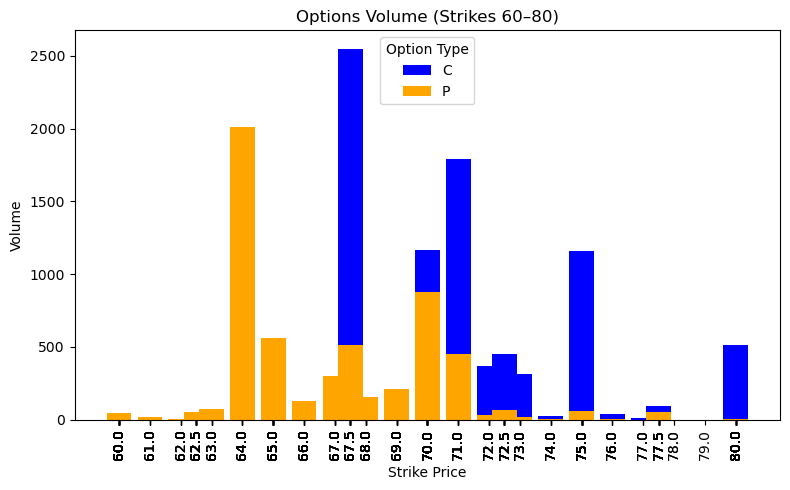

In [2069]:
fig, ax = plt.subplots(figsize=(8, 5))

for opt_type, color in zip(['C', 'P'], ['blue', 'orange']):
    subset = df_filtered[df_filtered['optionType'] == opt_type]
    ax.bar(subset['strike'], subset['volume'], label=opt_type, color=color)

# Labels & legend
ax.set_xlabel('Strike Price')
ax.set_ylabel('Volume')
ax.set_title('Options Volume (Strikes 60–80)')
ax.legend(title='Option Type')

# Force ticks only for filtered strikes
ax.set_xticks(df_filtered['strike'])
ax.set_xticklabels(df_filtered['strike'], rotation=90)

plt.tight_layout()
plt.show()

# Creating a bar chart to show the open interest of calls and puts by strike

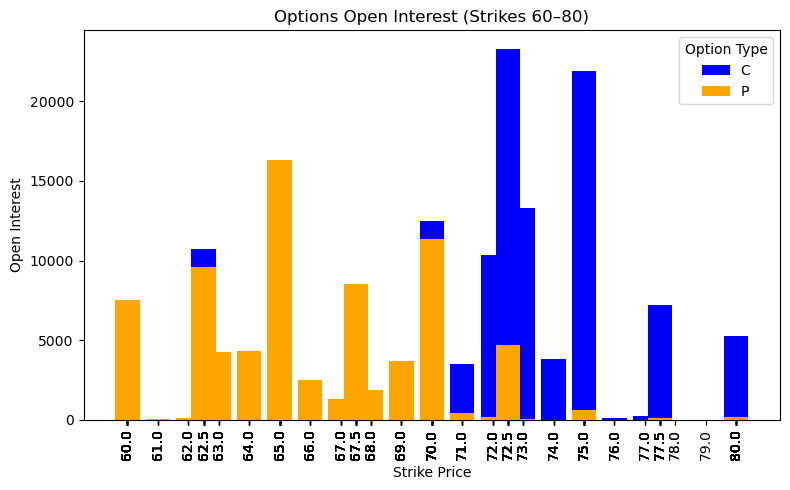

In [2071]:
fig, ax = plt.subplots(figsize=(8, 5))

for opt_type, color in zip(['C', 'P'], ['blue', 'orange']):
    subset = df_filtered[df_filtered['optionType'] == opt_type]
    ax.bar(subset['strike'], subset['openInterest'], label=opt_type, color=color)

# Labels & legend
ax.set_xlabel('Strike Price')
ax.set_ylabel('Open Interest')
ax.set_title('Options Open Interest (Strikes 60–80)')
ax.legend(title='Option Type')

# Force ticks only for filtered strikes
ax.set_xticks(df_filtered['strike'])
ax.set_xticklabels(df_filtered['strike'], rotation=90)

plt.tight_layout()
plt.show()

# Creating a new data frame of the previous grouping

In [2073]:
data = pd.DataFrame(grouped_filtered_sorted)
data = data.drop(data.columns[-1], axis=1)

# Converting updated data into a csv file

In [2075]:
data.to_csv('most ko calls puts traded by volume.csv')

# Printing latest option traded

In [2077]:
data = data.sort_values(by='time_traded', ascending=False)

In [2078]:
data.head(10)

Empty DataFrame
Columns: []
Index: [(70.0, P, 2025-08-22, 189.0, 389, 2025-08-13, 12:59:57), (70.0, P, 2025-08-15, 880.0, 8519, 2025-08-13, 12:59:42), (75.0, C, 2025-08-22, 1.0, 266, 2025-08-13, 12:59:40), (71.0, C, 2025-08-22, 1336.0, 1322, 2025-08-13, 12:59:37), (77.5, C, 2026-12-18, 2.0, 87, 2025-08-04, 12:59:24), (72.5, P, 2026-01-16, 6.0, 2561, 2025-08-13, 12:59:17), (68.0, P, 2025-08-15, 154.0, 1859, 2025-08-13, 12:59:13), (71.0, C, 2025-08-15, 1793.0, 3480, 2025-08-13, 12:59:12), (70.0, C, 2025-08-22, 165.0, 1225, 2025-08-13, 12:58:55), (60.0, C, 2025-11-21, 1.0, 161, 2025-08-11, 12:58:47)]